In [1]:
%matplotlib qt
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import time

import ssm_timeSeries as ts  # my self-written time series overhead
import ssm_fit               # my self-written library for state-space model fitting

from IPython import display  # for live plotting

import random
from datetime import datetime     # generate random seed for 
random.seed(datetime.now())       # np.random. Once this is fixed, all 
rngSeed = random.randint(0, 1000) # other 'randomness' is also fixed

from scipy.io import savemat # store results for comparison with Matlab code

xDim = 5
yDim = 15

T = 100000
Trial = 1


subpops = [list(range(4,yDim)), list(range(0,yDim-4))]
obsTime = [int(round(T/4)), int(round(2*T/3)), T]
obsPops = [0,1,0]
obsScheme = {'subpops': subpops,
             'obsTime': obsTime,
             'obsPops': obsPops}
[obsIdxG, idxgrps] = ssm_fit._computeObsIndexGroups(obsScheme,yDim)
obsScheme['obsIdxG'] = obsIdxG # add index groups and 
obsScheme['idxgrps'] = idxgrps # their occurences        


while True:
    W    = np.random.normal(size=[xDim,xDim])
    if np.abs(np.linalg.det(W)) > 0.001:
        break
A    = np.diag(np.linspace(0.1,0.95,xDim))  #np.diag(np.random.uniform(size=[xDim]))
A    = np.dot(np.dot(W, A), np.linalg.inv(W))
Qnoise = np.random.normal(size=[xDim,xDim])/9
Qnoise = np.dot(Qnoise, Qnoise.transpose())
Q    = np.identity(xDim) + Qnoise
mu0  = np.random.normal(size=[xDim]) #np.random.normal(size=[xDim])
V0   = np.identity(xDim)
C = np.random.normal(size=[yDim, xDim])
R = np.identity(yDim) + np.diag(np.abs(np.random.normal(size=[yDim])))
R[0,0] = 5
R[1,1] = 3
R[2,2] = 9
R[3,3] = 4


d  = np.arange(yDim)
d -= 10

uDim = 1
B = np.random.normal(size=[xDim,uDim])
B = B * 0

ifUseB = False

ifDataGeneratedWithInput = False

ifInputPiecewiseConstant = True
constantInputLength = 5000
u = np.zeros([uDim,T,Trial])
for tr in range(Trial):
    for i in range(int(np.floor(T/constantInputLength))):
        idxRange = range((i-1)*constantInputLength, i*constantInputLength)
        u[:,idxRange,tr] = np.random.normal(size=[1])
    u[:,:,tr] -= np.mean(u[:,:,tr])

seq = ts.setStateSpaceModel('iLDS', [xDim,yDim,uDim], [A,B,Q,mu0,V0,C,d,R])  # initiate true model
seq.giveEmpirical().addData(Trial,T,[u],rngSeed)                             # draw toy data

# check implementation of E- and M- step by doing one such step each:
x = seq.giveEmpirical().giveData().giveTracesX()
y = seq._empirical._data.giveTracesY()          

plt.plot(x[0,range(300),0])

no data model. Assuming data is given by real experiment or other external source
checking factorization of model ...
... factorization (locally) describes directed acyclic graph


In [2]:
%matplotlib qt

[Ext_true, Extxt_true, Extxtm1_true, LLtr] = ssm_fit._LDS_E_step(A,B,Q,mu0,V0,C,d,R,
                                                                 y,u,obsScheme)


elapsed time for fitting is
282.9534842967987


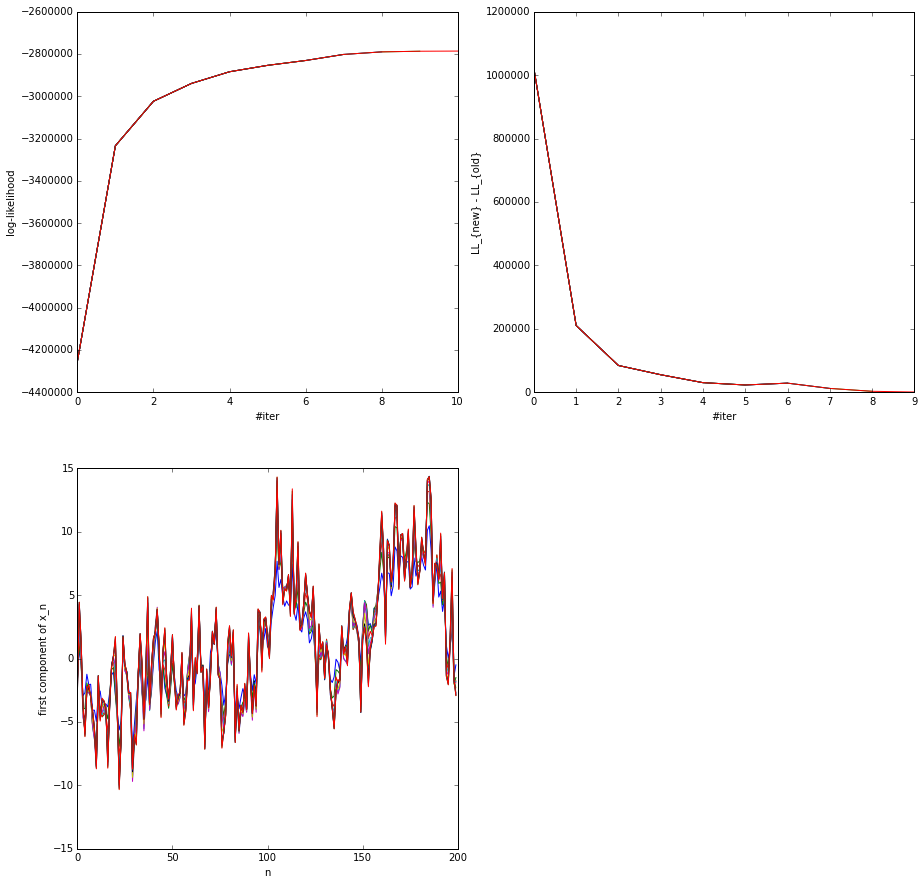

In [3]:
# initiate parameters for analysis model
A_0   = np.diag(np.random.uniform(size=[xDim]))
Q_0   = 50*np.identity(xDim)              
mu0_0 = 5*np.random.normal(size=[xDim])   
V0_0  = 50*np.identity(xDim)               
C_0   = np.random.normal(size=[yDim,xDim]) 
d_0   = np.random.normal(size=yDim)
d_0    = np.mean(y,(1,2))          
R_0   = 50*np.identity(yDim)    
B_0   = 0 * np.random.normal(size=[xDim, uDim])                                  

initPars         = [A_0,B_0,Q_0,mu0_0,V0_0,C_0,d_0,R_0]
maxIter          = 10
epsilon          = np.log(1.01)
ifPlotProgress   = True
ifTraceParamHist = False
ifRDiagonal      = True
t = time.time()
%matplotlib inline

[[A_h],[B_h],[Q_h],[mu0_h],[V0_h],[C_h],[d_h],[R_h],LL] = ssm_fit._fitLDS(
            y, 
            u,
            obsScheme,
            initPars, 
            maxIter, 
            epsilon, 
            ifPlotProgress, 
            ifTraceParamHist,
            ifRDiagonal,
            ifUseB,
            xDim)

elapsedTime = time.time() - t
print('elapsed time for fitting is')
print(elapsedTime)

if ifUseB:
    [Ext_h, Extxt_h, Extxtm1_h, LL_h]          = ssm_fit._LDS_E_step(A_h,B_h,Q_h,mu0_h,V0_h,C_h,d_h,R_h, 
                                                                     y,u,obsScheme)
else:
    [Ext_h, Extxt_h, Extxtm1_h, LL_h]          = ssm_fit._LDS_E_step(A_h,B_h,Q_h,mu0_h,V0_h,C_h,d_h,R_h, 
                                                                     y,None,obsScheme)
    

Pi_h    = np.array([sp.linalg.solve_discrete_lyapunov(A_h, Q_h)])[0,:,:]
Pi_t_h  = np.dot(A_h.transpose(), Pi_h)

Pi    = np.array([sp.linalg.solve_discrete_lyapunov(A, Q)])[0,:,:]
Pi_t  = np.dot(A.transpose(), Pi)

In [4]:

dataCov  = np.cov(y[:,0:T-1,0], y[:,1:T,0])
covyy    = dataCov[np.ix_(np.arange(0, yDim), np.arange(0,     yDim))]
covyy_m1 = dataCov[np.ix_(np.arange(0, yDim), np.arange(yDim,2*yDim))]

%matplotlib qt
plt.figure(1)
cmap = matplotlib.cm.get_cmap('brg')
clrs = [cmap(i) for i in np.linspace(0, 1, xDim)]
for i in range(xDim):
    plt.subplot(xDim,1,i)
    plt.plot(x[i,:,0], color=clrs[i])
    plt.hold(True)
    if np.mean( np.square(x[i,:,0] - Ext_h[i,:,0]) ) < np.mean( np.square(x[i,:,0] + Ext_h[i,:,0]) ):
        plt.plot( Ext_h[i,:,0], color=clrs[i], ls=':')
    else:
        plt.plot(-Ext_h[i,:,0], color=clrs[i], ls=':')
m = covyy.min()
M = covyy.max()        
plt.figure(2)
plt.subplot(1,3,1)
plt.imshow(np.dot(np.dot(C_h, Pi_h), C_h.transpose()) + R_h, interpolation='none')
plt.title('cov_hat(y_t,y_t)')
plt.clim(m,M)
plt.subplot(1,3,2)
plt.imshow(covyy,    interpolation='none')
plt.title('cov_emp(y_t,y_t)')
plt.clim(m,M)
plt.subplot(1,3,3)
plt.imshow(np.dot(np.dot(C, Pi), C.transpose()) + R, interpolation='none')
plt.title('cov_true(y_t,y_t)')
plt.clim(m,M)
plt.figure(3)

m = covyy_m1.min()
M = covyy_m1.max()        
plt.subplot(1,3,1)
plt.imshow(np.dot(np.dot(C_h, Pi_t_h), C_h.transpose()), interpolation='none')
plt.title('cov_hat(y_t,y_{t-1})')
plt.clim(m,M)
plt.subplot(1,3,2)
plt.imshow(covyy_m1,    interpolation='none')
plt.title('cov(y_t,y_{t-1})')
plt.clim(m,M)
plt.subplot(1,3,3)
plt.imshow(np.dot(np.dot(C, Pi_t), C.transpose()), interpolation='none')
plt.title('cov_true(y_t,y_{t-1})')
plt.clim(m,M)
plt.figure(4)
plt.plot(np.sort(np.linalg.eig(A)[0]), 'r')
plt.hold(True)
plt.plot(np.sort(np.linalg.eig(A_h)[0]), 'b')
plt.legend(['true', 'est'])


#matlabSaveFile = {'x': x, 'y': y, 'u' : u, 
#                  'A':A, 'B':B, 'Q':Q, 'mu0':mu0,'V0':V0,'C':C,'d':d,'R':R,
#                  'A_0':A_0, 'B_0':B_0, 'Q_0':Q_0, 'mu0_0':mu0_0,'V0_0':V0_0,'C_0':C_0,'d_0':d_0,'R_0':R_0,
#                  'A_1':A_1, 'B_1':B_1, 'Q_1':Q_1, 'mu0_1':mu0_1,'V0_1':V0_1,'C_1':C_1,'d_1':d_1,'R_1':R_1,
#                  'A_h':A_h, 'Q_h':Q_h, 'mu0_h':mu0_h,'V0_h':V0_h,'C_h':C_h,'R_h':R_h,
#                  'Ext':Ext, 'Extxt':Extxt, 'Extxtm1':Extxtm1,
#                  'T':T,
#                  'LL0': LL0, 'LL1': LL1}
#savemat('LDS_data.mat',matlabSaveFile)

/home/mackelab/anaconda/envs/py3k/lib/python3.3/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


In [7]:
matlabSaveFile = {'x': x, 'y': y, 'u' : u, 
                  'A':A, 'B':B, 'Q':Q, 'mu0':mu0,'V0':V0,'C':C,'d':d,'R':R,
                  'A_0':A_0, 'B_0':B_0, 'Q_0':Q_0, 'mu0_0':mu0_0,'V0_0':V0_0,'C_0':C_0,'d_0':d_0,'R_0':R_0,
                  'A_1':A_1, 'B_1':B_1, 'Q_1':Q_1, 'mu0_1':mu0_1,'V0_1':V0_1,'C_1':C_1,'d_1':d_1,'R_1':R_1,
                  'A_h':A_h, 'Q_h':Q_h, 'mu0_h':mu0_h,'V0_h':V0_h,'C_h':C_h,'R_h':R_h,
                  'Ext':Ext, 'Extxt':Extxt, 'Extxtm1':Extxtm1,
                  'T':T,
                  'LL0': LL0, 'LL1': LL1}
savemat('LDS_data.mat',matlabSaveFile)


In [5]:
matlabSaveFile = {'x': x, 'y': y, 'u' : u, 'LL' : LL,
                  'ifDataGeneratedWithInput' : ifDataGeneratedWithInput, 
                  'ifInputPiecewiseConstant' : ifInputPiecewiseConstant,
                  'constantInputLength' : constantInputLength,
                  'A':A, 'B':B, 'Q':Q, 'mu0':mu0,'V0':V0,'C':C,'d':d,'R':R,
                  'A_h':A_h, 'Q_h':Q_h, 'mu0_h':mu0_h,'V0_h':V0_h,'C_h':C_h,'d_h':d_h, 'R_h':R_h,
                  'Ext_h':Ext_h, 'Extxt_h':Extxt_h, 'Extxtm1_h':Extxtm1_h,
                  'Ext_true':Ext_true, 'Extxt_true':Extxt_true, 'Extxtm1':Extxtm1_true,
                  'Pi' : Pi, 'Pi_h' : Pi_h, 'Pi_t' : Pi_t, 'Pi_t_h': Pi_t_h,
                  'obsScheme' : obsScheme}
savemat('LDS_data_to_visualise.mat',matlabSaveFile)


In [4]:
import numpy as np
data = np.loadtxt('/home/mackelab/Desktop/Projects/Stitching/data/ChaLearn_Challenge_Connectomics/fluorescence_iNet1_Size100_CC02inh.txt', delimiter=',')

In [7]:
np.mean(data,0)

array([ 0.13051865,  0.12292294,  0.13287707,  0.11159466,  0.12670285,
        0.14606726,  0.16176954,  0.15578829,  0.09934942,  0.14120863,
        0.13965303,  0.16317934,  0.11167378,  0.16169645,  0.14557485,
        0.16368932,  0.12848402,  0.15396086,  0.11724236,  0.17125651,
        0.14316147,  0.137222  ,  0.16089579,  0.1260918 ,  0.12977888,
        0.12803991,  0.09775933,  0.15513544,  0.18077759,  0.12542609,
        0.11550152,  0.17332058,  0.13276486,  0.12621307,  0.15568124,
        0.14149027,  0.14694395,  0.15267428,  0.12285181,  0.12921596,
        0.11453667,  0.12229861,  0.09861661,  0.14131816,  0.17184028,
        0.18181101,  0.16161289,  0.12642143,  0.16254373,  0.15741639,
        0.10669373,  0.1567145 ,  0.15681771,  0.15182435,  0.14926585,
        0.14873548,  0.17496491,  0.11827658,  0.17510192,  0.14310373,
        0.15496652,  0.11552721,  0.1386945 ,  0.12641384,  0.14763943,
        0.14595629,  0.15507986,  0.13598936,  0.16051972,  0.13